# Using R via rpy2

This example illustrates how to use models, summary statistics and
distance functions defined in R. We're assuming you're already
familiar with the basic workings of pyABC. If not, consult the
other tutorial examples.

In [1]:
# install if not done yet
!pip install pyabc[r] --quiet

In [1]:
%matplotlib inline
from pyabc.external.r import R

r = R("myRModel.R")

/home/yannik/pyabc/pyabc/external/r/r_rpy2.py:81: UserWarning: The support of R via rpy2 is considered experimental.
  warnings.warn("The support of R via rpy2 is considered experimental.")


In [2]:
r.display_source_ipython()

We see that four relevant objects are defined in the file.

* myModel
* mySummaryStatistics (optional)
* myDistance
* mySumStatData

The names of these do not matter. The ``mySummaryStatistics`` is actually optional and can be omitted
in case the model calculates the summary statistics directly. We load the defined functions using the ``r`` object:

In [3]:
model = r.model("myModel")
distance = r.distance("myDistance")
sum_stat = r.summary_statistics("mySummaryStatistics")

From there on, we can use them (almost) as if they were ordinary Python functions.

In [4]:
import pyabc
from pyabc import ABCSMC, RV, Distribution

pyabc.settings.set_figure_params('pyabc')  # for beautified plots

prior = Distribution(meanX=RV("uniform", 0, 10), meanY=RV("uniform", 0, 10))
abc = ABCSMC(model, prior, distance, summary_statistics=sum_stat)

ABC.Sampler INFO: Parallelize sampling on 4 processes.


We also load the observation with ``r.observation`` and pass it to a new ABC run.

In [5]:
import os
from tempfile import gettempdir

db = "sqlite:///" + os.path.join(gettempdir(), "test.db")
abc.new(db, r.observation("mySumStatData"))

ABC.History INFO: Start <ABCSMC id=1, start_time=2021-11-18 15:44:06>


We start a run which terminates as soon as an acceptance threshold of 0.9 or less is reached
or the maximum number of 4 populations is sampled.

In [6]:
history = abc.run(minimum_epsilon=0.9, max_nr_populations=4)

ABC INFO: Calibration sample t = -1.
ABC INFO: t: 0, eps: 4.33680673e+00.
ABC INFO: Accepted: 100 / 240 = 4.1667e-01, ESS: 1.0000e+02.
ABC INFO: t: 1, eps: 2.94456492e+00.
ABC INFO: Accepted: 100 / 256 = 3.9062e-01, ESS: 9.7804e+01.
ABC INFO: t: 2, eps: 1.88636339e+00.
ABC INFO: Accepted: 100 / 289 = 3.4602e-01, ESS: 8.9331e+01.
ABC INFO: t: 3, eps: 1.23695847e+00.
ABC INFO: Accepted: 100 / 471 = 2.1231e-01, ESS: 8.4991e+01.
ABC INFO: Stop: Maximum number of generations.
ABC.History INFO: Done <ABCSMC id=1, duration=0:00:09.465072, end_time=2021-11-18 15:44:15>


Lastly, we plot the results and observe how the generations contract slowly around the oserved value.
(Note, that the contraction around the observed value is a particular property of the chosen example and not always the case.)

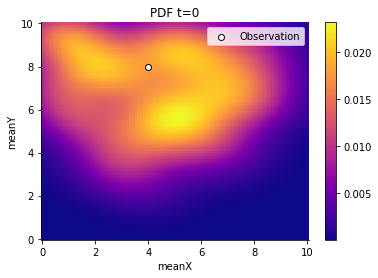

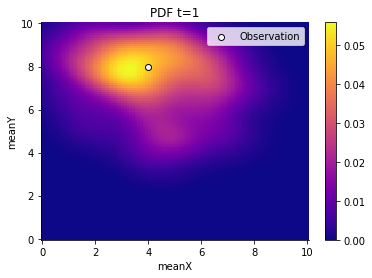

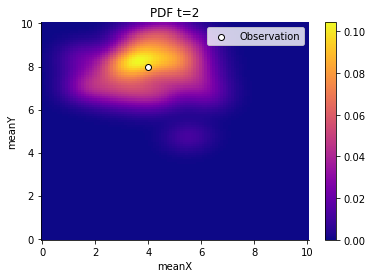

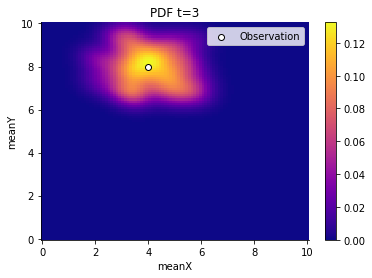

In [7]:
from pyabc.visualization import plot_kde_2d

for t in range(history.n_populations):
    df, w = abc.history.get_distribution(0, t)
    ax = plot_kde_2d(
        df,
        w,
        "meanX",
        "meanY",
        xmin=0,
        xmax=10,
        ymin=0,
        ymax=10,
        numx=100,
        numy=100,
    )
    ax.scatter(
        [4], [8], edgecolor="black", facecolor="white", label="Observation"
    )
    ax.legend()
    ax.set_title(f"PDF t={t}")

And we can also retrieve summary statistics such as a stored
DataFrame, although the DataFrame was acutally defined in R.

In [8]:
history.get_weighted_sum_stats_for_model(m=0, t=1)[1][0]["cars"].head()

,speed,dist
1,4.0,2.0
2,4.0,10.0
3,7.0,4.0
4,7.0,22.0
5,8.0,16.0
